<a href="https://colab.research.google.com/github/gpapadok/gan-variations/blob/master/vanilla_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [0]:
# PARAMETERS
LR = .0002
BETA1 = .5
EPOCHS = 1
BATCH_SIZE = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.,), (1.,))
     ])

try:
  trainset = torchvision.datasets.MNIST('./data', transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
except RuntimeError:
  trainset = torchvision.datasets.MNIST('./data', download=True, transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [0]:
# print(trainset)
# print(testset)

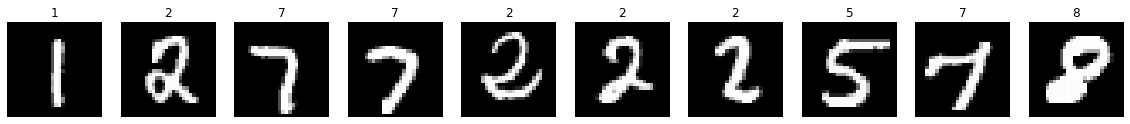

In [46]:
def plot_digits(dataset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.lin1 = nn.Linear(100, 256)
    self.lin2 = nn.Linear(256, 512)
    self.lin3 = nn.Linear(512, 1024)
    self.lin4 = nn.Linear(1024, 784)
    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input):
    x = self.leaky_relu(self.lin1(input))
    x = self.leaky_relu(self.lin2(x))
    x = self.leaky_relu(self.lin3(x))
    x = self.leaky_relu(self.lin4(x))
    return torch.tanh(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.lin1 = nn.Linear(784, 1024)
    self.lin2 = nn.Linear(1024, 512)
    self.lin3 = nn.Linear(512, 256)
    self.lin4 = nn.Linear(256, 1)
    self.leaky_relu = nn.LeakyReLU(.2)
    self.dropout = nn.Dropout(.3)

  def forward(self, input):
    x = input.view(-1, 784)
    x = self.leaky_relu(self.lin1(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin2(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin3(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin4(x))
    return torch.sigmoid(x)

In [0]:
class GAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch):
    return self.generator(batch)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    fake = self.generate_fake(noise).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs=EPOCHS, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_history = []
    try:
      for epoch in range(epochs):
        if epoch % 5 == 0:
          self.plot_ten_samples()

        epoch_gerr = []
        epoch_derr = []
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          self.optimD.zero_grad()

          # Train with real
          real = data[0].to(device)
          batch_size = real.size()[0]
          real_labels = torch.ones(batch_size, 1, device=device) * .9
          out = self.discriminator(real)
          errD_real = self.loss(out, real_labels)
          errD_real.backward()

          # Train with fake
          noise = torch.randn(batch_size, 100, device=device)
          fake = self.generate_fake(noise)
          fake_labels = torch.ones(batch_size, 1, device=device) * .1
          out = self.discriminator(fake)
          errD_fake = self.loss(out, fake_labels)
          errD_fake.backward()

          self.optimD.step()

          epoch_derr += [(errD_real.item()+errD_fake.item())*.5]

          # TRAIN GENERATOR
          self.optimG.zero_grad()

          noise = torch.randn(batch_size, 100, device=device)
          fake = self.generate_fake(noise)
          fake_labels = torch.ones(batch_size, 1, device=device)
          out = self.discriminator(fake)
          errG = self.loss(out, fake_labels)
          errG.backward()

          self.optimG.step()

          epoch_gerr += [errG.item()]

        errD_history += [torch.tensor(epoch_derr).mean()]
        errG_history += [torch.tensor(epoch_gerr).mean()]

        print(f'EPOCH {epoch+1:2}/{epochs}')
        print(f"disc_loss: {errD_history[-1]:.4f} - gen_loss: {errG_history[-1]:.4f}")
    except KeyboardInterrupt:
      return errG_history, errD_history


          
    return errG_history, errD_history

In [0]:
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [0]:
loss = nn.BCELoss()
optimizerD = torch.optim.Adam(dnet.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = torch.optim.Adam(gnet.parameters(), lr=LR, betas=(BETA1, 0.999))

gan = GAN(gnet, dnet, loss, optimizerG, optimizerD)

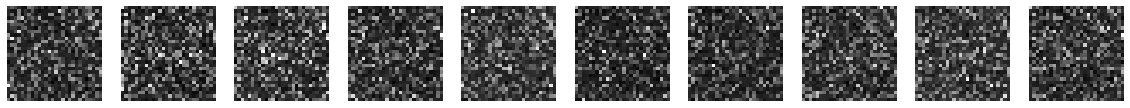

EPOCH  1/200
disc_loss: 0.5562 - gen_loss: 1.0604
EPOCH  2/200
disc_loss: 0.4834 - gen_loss: 2.1701
EPOCH  3/200
disc_loss: 0.4649 - gen_loss: 2.2331
EPOCH  4/200
disc_loss: 0.4653 - gen_loss: 2.2179
EPOCH  5/200
disc_loss: 0.4651 - gen_loss: 2.1457


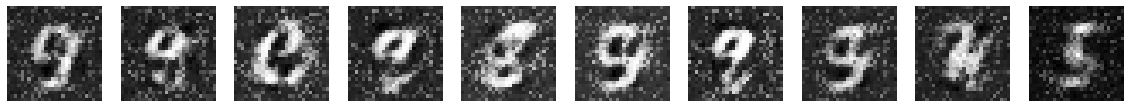

EPOCH  6/200
disc_loss: 0.4632 - gen_loss: 2.0276
EPOCH  7/200
disc_loss: 0.4643 - gen_loss: 1.9485
EPOCH  8/200
disc_loss: 0.4700 - gen_loss: 1.9036
EPOCH  9/200
disc_loss: 0.4699 - gen_loss: 1.8321
EPOCH 10/200
disc_loss: 0.4676 - gen_loss: 1.8117


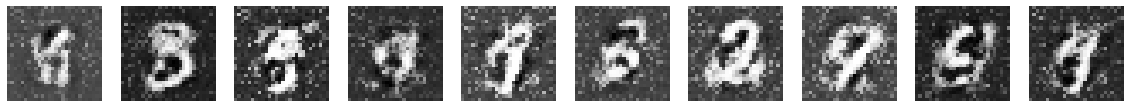

EPOCH 11/200
disc_loss: 0.4827 - gen_loss: 1.7596
EPOCH 12/200
disc_loss: 0.5001 - gen_loss: 1.6241
EPOCH 13/200
disc_loss: 0.5129 - gen_loss: 1.5657
EPOCH 14/200
disc_loss: 0.5195 - gen_loss: 1.5124
EPOCH 15/200
disc_loss: 0.5226 - gen_loss: 1.4688


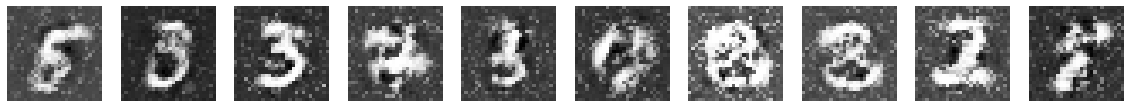

EPOCH 16/200
disc_loss: 0.5267 - gen_loss: 1.4575
EPOCH 17/200
disc_loss: 0.5286 - gen_loss: 1.4282
EPOCH 18/200
disc_loss: 0.5290 - gen_loss: 1.4206
EPOCH 19/200
disc_loss: 0.5276 - gen_loss: 1.4237
EPOCH 20/200
disc_loss: 0.5261 - gen_loss: 1.4242


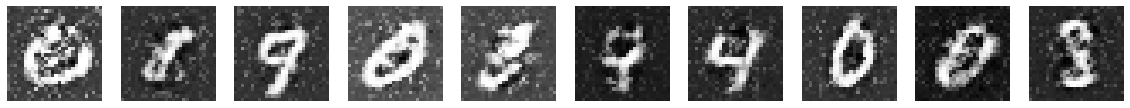

EPOCH 21/200
disc_loss: 0.5204 - gen_loss: 1.4479
EPOCH 22/200
disc_loss: 0.5202 - gen_loss: 1.4503
EPOCH 23/200
disc_loss: 0.5187 - gen_loss: 1.4530
EPOCH 24/200
disc_loss: 0.5174 - gen_loss: 1.4567
EPOCH 25/200
disc_loss: 0.5139 - gen_loss: 1.4685


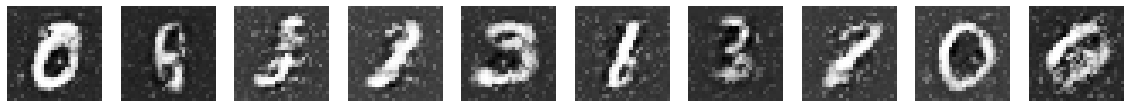

EPOCH 26/200
disc_loss: 0.5121 - gen_loss: 1.4800
EPOCH 27/200
disc_loss: 0.5086 - gen_loss: 1.4877
EPOCH 28/200
disc_loss: 0.5082 - gen_loss: 1.4912
EPOCH 29/200
disc_loss: 0.5030 - gen_loss: 1.5145
EPOCH 30/200
disc_loss: 0.5015 - gen_loss: 1.5271


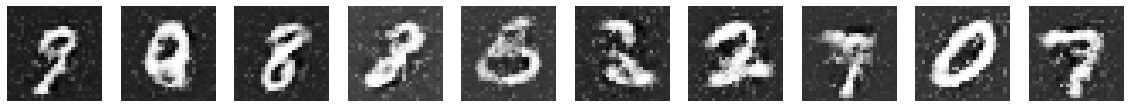

EPOCH 31/200
disc_loss: 0.4983 - gen_loss: 1.5381
EPOCH 32/200
disc_loss: 0.4948 - gen_loss: 1.5525
EPOCH 33/200
disc_loss: 0.4944 - gen_loss: 1.5547
EPOCH 34/200
disc_loss: 0.4894 - gen_loss: 1.5696
EPOCH 35/200
disc_loss: 0.4882 - gen_loss: 1.5818


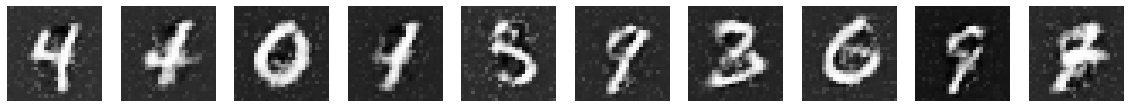

EPOCH 36/200
disc_loss: 0.4842 - gen_loss: 1.6052
EPOCH 37/200
disc_loss: 0.4814 - gen_loss: 1.6104
EPOCH 38/200
disc_loss: 0.4795 - gen_loss: 1.6247
EPOCH 39/200
disc_loss: 0.4765 - gen_loss: 1.6418
EPOCH 40/200
disc_loss: 0.4748 - gen_loss: 1.6544


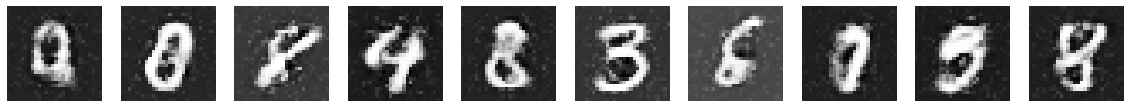

EPOCH 41/200
disc_loss: 0.4739 - gen_loss: 1.6540
EPOCH 42/200
disc_loss: 0.4723 - gen_loss: 1.6570
EPOCH 43/200
disc_loss: 0.4705 - gen_loss: 1.6692
EPOCH 44/200
disc_loss: 0.4675 - gen_loss: 1.6886
EPOCH 45/200
disc_loss: 0.4664 - gen_loss: 1.6852


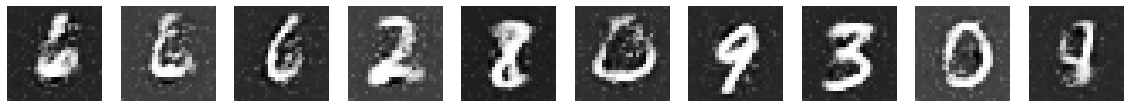

EPOCH 46/200
disc_loss: 0.4655 - gen_loss: 1.6945
EPOCH 47/200
disc_loss: 0.4632 - gen_loss: 1.7022
EPOCH 48/200
disc_loss: 0.4616 - gen_loss: 1.7082
EPOCH 49/200
disc_loss: 0.4608 - gen_loss: 1.7173
EPOCH 50/200
disc_loss: 0.4611 - gen_loss: 1.7176


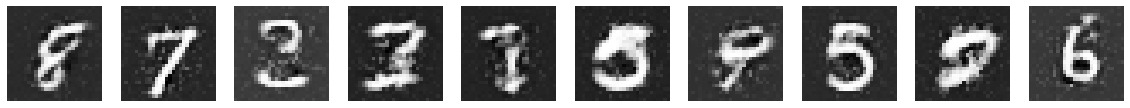

EPOCH 51/200
disc_loss: 0.4598 - gen_loss: 1.7126
EPOCH 52/200
disc_loss: 0.4599 - gen_loss: 1.7175
EPOCH 53/200
disc_loss: 0.4572 - gen_loss: 1.7290
EPOCH 54/200
disc_loss: 0.4566 - gen_loss: 1.7423
EPOCH 55/200
disc_loss: 0.4557 - gen_loss: 1.7361


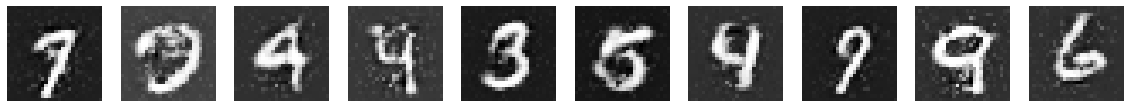

EPOCH 56/200
disc_loss: 0.4553 - gen_loss: 1.7509
EPOCH 57/200
disc_loss: 0.4553 - gen_loss: 1.7349
EPOCH 58/200
disc_loss: 0.4539 - gen_loss: 1.7532
EPOCH 59/200
disc_loss: 0.4541 - gen_loss: 1.7441
EPOCH 60/200
disc_loss: 0.4539 - gen_loss: 1.7423


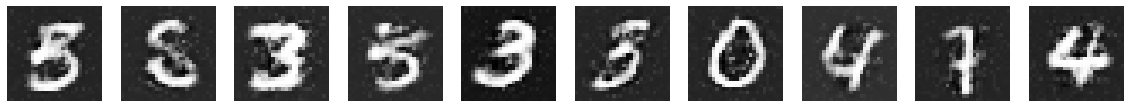

EPOCH 61/200
disc_loss: 0.4537 - gen_loss: 1.7514
EPOCH 62/200
disc_loss: 0.4506 - gen_loss: 1.7606
EPOCH 63/200
disc_loss: 0.4533 - gen_loss: 1.7527
EPOCH 64/200
disc_loss: 0.4527 - gen_loss: 1.7516
EPOCH 65/200
disc_loss: 0.4516 - gen_loss: 1.7504


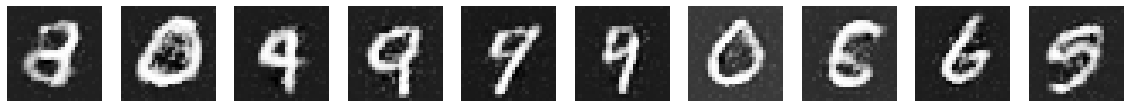

EPOCH 66/200
disc_loss: 0.4497 - gen_loss: 1.7664
EPOCH 67/200
disc_loss: 0.4494 - gen_loss: 1.7700
EPOCH 68/200
disc_loss: 0.4514 - gen_loss: 1.7465
EPOCH 69/200
disc_loss: 0.4497 - gen_loss: 1.7705
EPOCH 70/200
disc_loss: 0.4501 - gen_loss: 1.7655


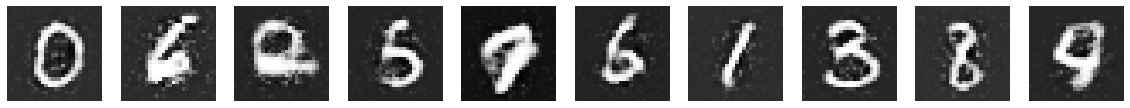

EPOCH 71/200
disc_loss: 0.4513 - gen_loss: 1.7680
EPOCH 72/200
disc_loss: 0.4485 - gen_loss: 1.7690
EPOCH 73/200
disc_loss: 0.4512 - gen_loss: 1.7564
EPOCH 74/200
disc_loss: 0.4490 - gen_loss: 1.7624
EPOCH 75/200
disc_loss: 0.4493 - gen_loss: 1.7694


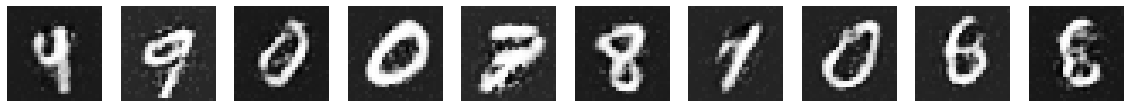

EPOCH 76/200
disc_loss: 0.4484 - gen_loss: 1.7663
EPOCH 77/200
disc_loss: 0.4483 - gen_loss: 1.7585
EPOCH 78/200
disc_loss: 0.4476 - gen_loss: 1.7801
EPOCH 79/200
disc_loss: 0.4468 - gen_loss: 1.7754
EPOCH 80/200
disc_loss: 0.4491 - gen_loss: 1.7597


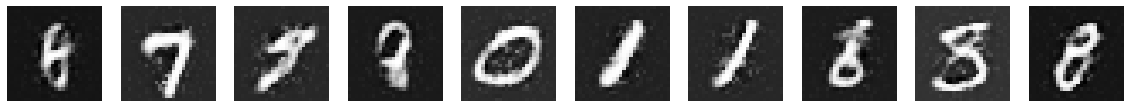

EPOCH 81/200
disc_loss: 0.4482 - gen_loss: 1.7732
EPOCH 82/200
disc_loss: 0.4489 - gen_loss: 1.7648
EPOCH 83/200
disc_loss: 0.4477 - gen_loss: 1.7613
EPOCH 84/200
disc_loss: 0.4493 - gen_loss: 1.7617
EPOCH 85/200
disc_loss: 0.4477 - gen_loss: 1.7602


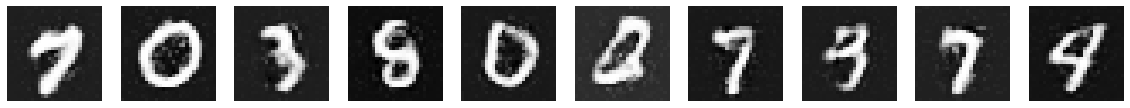

EPOCH 86/200
disc_loss: 0.4471 - gen_loss: 1.7710
EPOCH 87/200
disc_loss: 0.4471 - gen_loss: 1.7798
EPOCH 88/200
disc_loss: 0.4475 - gen_loss: 1.7695
EPOCH 89/200
disc_loss: 0.4491 - gen_loss: 1.7682
EPOCH 90/200
disc_loss: 0.4445 - gen_loss: 1.7750


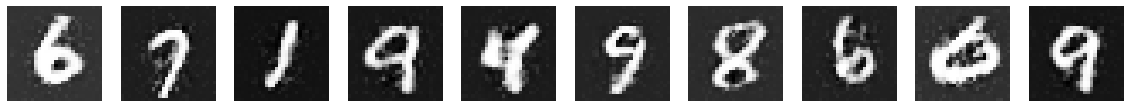

EPOCH 91/200
disc_loss: 0.4494 - gen_loss: 1.7667
EPOCH 92/200
disc_loss: 0.4468 - gen_loss: 1.7706
EPOCH 93/200
disc_loss: 0.4510 - gen_loss: 1.7635
EPOCH 94/200
disc_loss: 0.4452 - gen_loss: 1.7674
EPOCH 95/200
disc_loss: 0.4452 - gen_loss: 1.7763


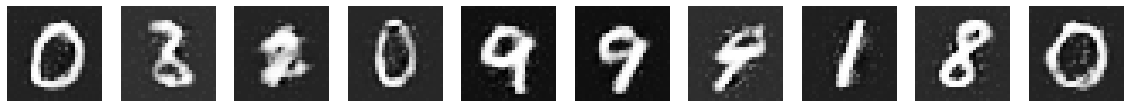

EPOCH 96/200
disc_loss: 0.4509 - gen_loss: 1.7518
EPOCH 97/200
disc_loss: 0.4481 - gen_loss: 1.7557
EPOCH 98/200
disc_loss: 0.4474 - gen_loss: 1.7709
EPOCH 99/200
disc_loss: 0.4476 - gen_loss: 1.7697
EPOCH 100/200
disc_loss: 0.4476 - gen_loss: 1.7685


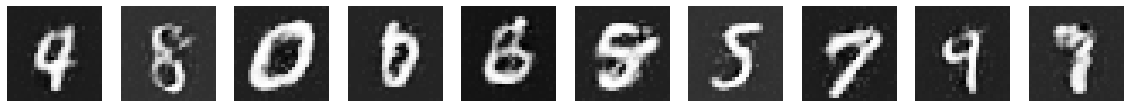

EPOCH 101/200
disc_loss: 0.4463 - gen_loss: 1.7669
EPOCH 102/200
disc_loss: 0.4472 - gen_loss: 1.7764
EPOCH 103/200
disc_loss: 0.4456 - gen_loss: 1.7759
EPOCH 104/200
disc_loss: 0.4490 - gen_loss: 1.7605
EPOCH 105/200
disc_loss: 0.4440 - gen_loss: 1.7708


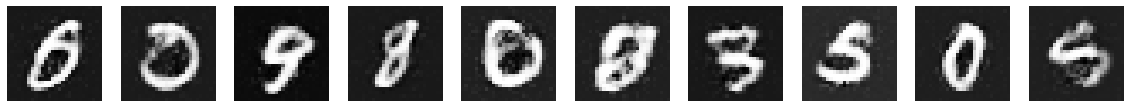

EPOCH 106/200
disc_loss: 0.4450 - gen_loss: 1.7786
EPOCH 107/200
disc_loss: 0.4459 - gen_loss: 1.7857
EPOCH 108/200
disc_loss: 0.4491 - gen_loss: 1.7635
EPOCH 109/200
disc_loss: 0.4491 - gen_loss: 1.7560
EPOCH 110/200
disc_loss: 0.4466 - gen_loss: 1.7707


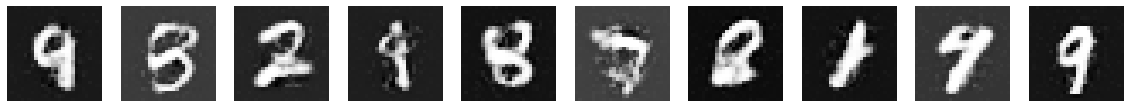

EPOCH 111/200
disc_loss: 0.4501 - gen_loss: 1.7641
EPOCH 112/200
disc_loss: 0.4442 - gen_loss: 1.7849
EPOCH 113/200
disc_loss: 0.4490 - gen_loss: 1.7638
EPOCH 114/200
disc_loss: 0.4480 - gen_loss: 1.7605
EPOCH 115/200
disc_loss: 0.4504 - gen_loss: 1.7569


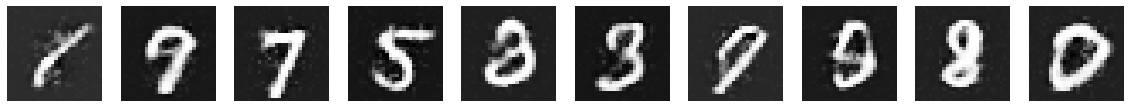

EPOCH 116/200
disc_loss: 0.4477 - gen_loss: 1.7656
EPOCH 117/200
disc_loss: 0.4447 - gen_loss: 1.7728
EPOCH 118/200
disc_loss: 0.4439 - gen_loss: 1.7813
EPOCH 119/200
disc_loss: 0.4466 - gen_loss: 1.7647
EPOCH 120/200
disc_loss: 0.4467 - gen_loss: 1.7685


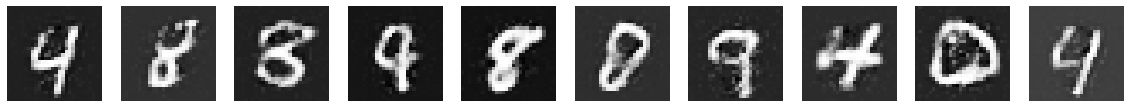

EPOCH 121/200
disc_loss: 0.4488 - gen_loss: 1.7634
EPOCH 122/200
disc_loss: 0.4449 - gen_loss: 1.7733
EPOCH 123/200
disc_loss: 0.4468 - gen_loss: 1.7665
EPOCH 124/200
disc_loss: 0.4467 - gen_loss: 1.7638
EPOCH 125/200
disc_loss: 0.4471 - gen_loss: 1.7630


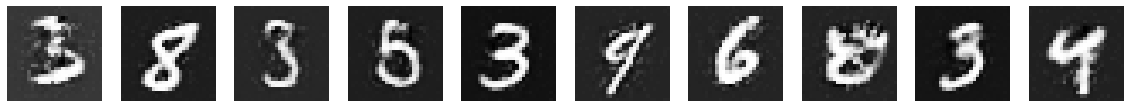

EPOCH 126/200
disc_loss: 0.4476 - gen_loss: 1.7650
EPOCH 127/200
disc_loss: 0.4476 - gen_loss: 1.7662
EPOCH 128/200
disc_loss: 0.4453 - gen_loss: 1.7658
EPOCH 129/200
disc_loss: 0.4488 - gen_loss: 1.7666
EPOCH 130/200
disc_loss: 0.4475 - gen_loss: 1.7659


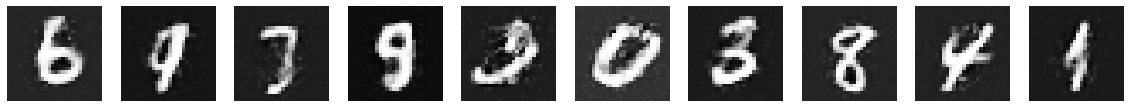

EPOCH 131/200
disc_loss: 0.4448 - gen_loss: 1.7788
EPOCH 132/200
disc_loss: 0.4475 - gen_loss: 1.7612
EPOCH 133/200
disc_loss: 0.4449 - gen_loss: 1.7703
EPOCH 134/200
disc_loss: 0.4450 - gen_loss: 1.7743
EPOCH 135/200
disc_loss: 0.4468 - gen_loss: 1.7660


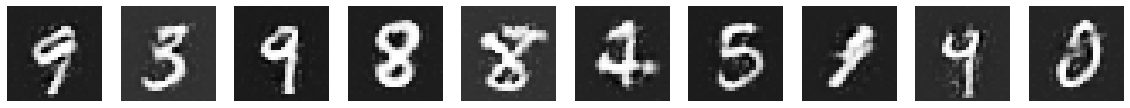

EPOCH 136/200
disc_loss: 0.4475 - gen_loss: 1.7699
EPOCH 137/200
disc_loss: 0.4447 - gen_loss: 1.7809
EPOCH 138/200
disc_loss: 0.4456 - gen_loss: 1.7680
EPOCH 139/200
disc_loss: 0.4457 - gen_loss: 1.7710
EPOCH 140/200
disc_loss: 0.4461 - gen_loss: 1.7690


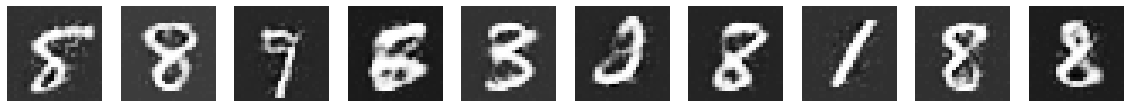

EPOCH 141/200
disc_loss: 0.4469 - gen_loss: 1.7716
EPOCH 142/200
disc_loss: 0.4432 - gen_loss: 1.7852
EPOCH 143/200
disc_loss: 0.4463 - gen_loss: 1.7685
EPOCH 144/200
disc_loss: 0.4470 - gen_loss: 1.7714
EPOCH 145/200
disc_loss: 0.4418 - gen_loss: 1.7883


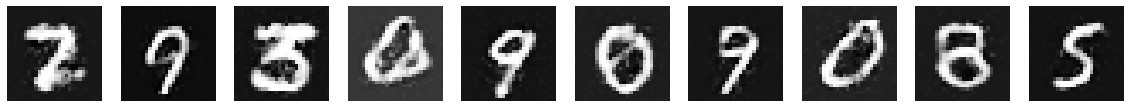

EPOCH 146/200
disc_loss: 0.4460 - gen_loss: 1.7725
EPOCH 147/200
disc_loss: 0.4463 - gen_loss: 1.7737
EPOCH 148/200
disc_loss: 0.4465 - gen_loss: 1.7658
EPOCH 149/200
disc_loss: 0.4452 - gen_loss: 1.7686
EPOCH 150/200
disc_loss: 0.4450 - gen_loss: 1.7906


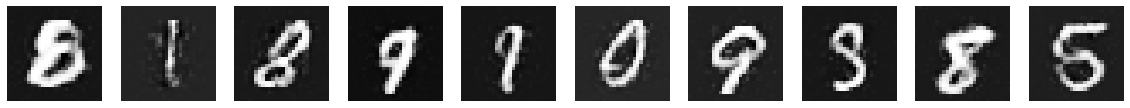

EPOCH 151/200
disc_loss: 0.4463 - gen_loss: 1.7668
EPOCH 152/200
disc_loss: 0.4426 - gen_loss: 1.7903
EPOCH 153/200
disc_loss: 0.4431 - gen_loss: 1.7831
EPOCH 154/200
disc_loss: 0.4464 - gen_loss: 1.7760
EPOCH 155/200
disc_loss: 0.4464 - gen_loss: 1.7696


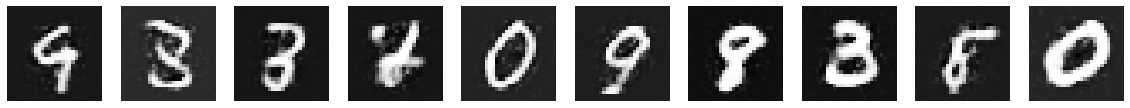

EPOCH 156/200
disc_loss: 0.4438 - gen_loss: 1.7757
EPOCH 157/200
disc_loss: 0.4451 - gen_loss: 1.7774
EPOCH 158/200
disc_loss: 0.4452 - gen_loss: 1.7785
EPOCH 159/200
disc_loss: 0.4433 - gen_loss: 1.7778
EPOCH 160/200
disc_loss: 0.4426 - gen_loss: 1.7975


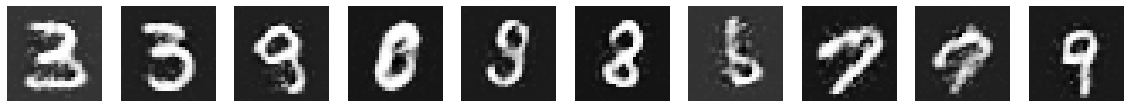

EPOCH 161/200
disc_loss: 0.4420 - gen_loss: 1.7872
EPOCH 162/200
disc_loss: 0.4465 - gen_loss: 1.7747
EPOCH 163/200
disc_loss: 0.4465 - gen_loss: 1.7801
EPOCH 164/200
disc_loss: 0.4433 - gen_loss: 1.7848
EPOCH 165/200
disc_loss: 0.4456 - gen_loss: 1.7803


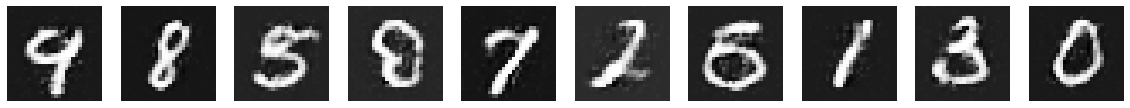

EPOCH 166/200
disc_loss: 0.4408 - gen_loss: 1.7952
EPOCH 167/200
disc_loss: 0.4457 - gen_loss: 1.7787
EPOCH 168/200
disc_loss: 0.4418 - gen_loss: 1.7858
EPOCH 169/200
disc_loss: 0.4437 - gen_loss: 1.7930
EPOCH 170/200
disc_loss: 0.4443 - gen_loss: 1.7819


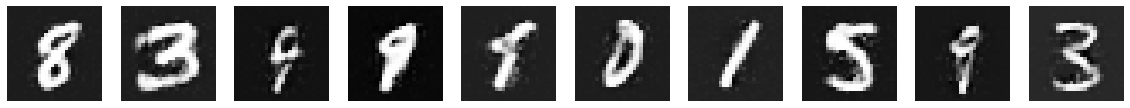

EPOCH 171/200
disc_loss: 0.4407 - gen_loss: 1.7978
EPOCH 172/200
disc_loss: 0.4396 - gen_loss: 1.7943
EPOCH 173/200
disc_loss: 0.4425 - gen_loss: 1.7915
EPOCH 174/200
disc_loss: 0.4420 - gen_loss: 1.8004
EPOCH 175/200
disc_loss: 0.4417 - gen_loss: 1.7987


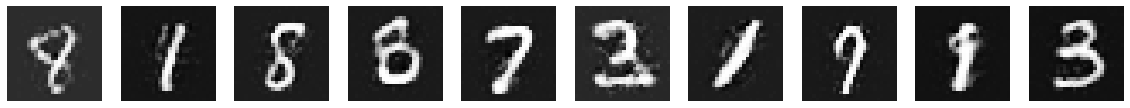

EPOCH 176/200
disc_loss: 0.4445 - gen_loss: 1.7859
EPOCH 177/200
disc_loss: 0.4449 - gen_loss: 1.7879
EPOCH 178/200
disc_loss: 0.4418 - gen_loss: 1.7876
EPOCH 179/200
disc_loss: 0.4426 - gen_loss: 1.7908
EPOCH 180/200
disc_loss: 0.4413 - gen_loss: 1.8019


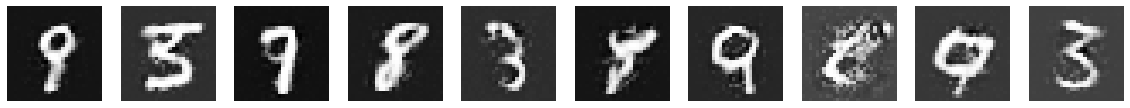

EPOCH 181/200
disc_loss: 0.4428 - gen_loss: 1.7873
EPOCH 182/200
disc_loss: 0.4395 - gen_loss: 1.8073
EPOCH 183/200
disc_loss: 0.4406 - gen_loss: 1.7976
EPOCH 184/200
disc_loss: 0.4408 - gen_loss: 1.7953
EPOCH 185/200
disc_loss: 0.4398 - gen_loss: 1.7968


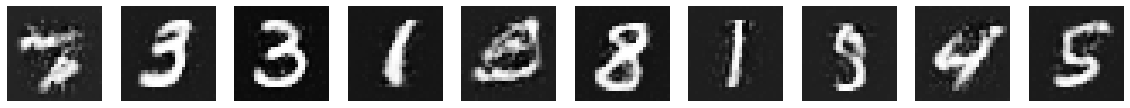

EPOCH 186/200
disc_loss: 0.4420 - gen_loss: 1.7849
EPOCH 187/200
disc_loss: 0.4420 - gen_loss: 1.7928
EPOCH 188/200
disc_loss: 0.4394 - gen_loss: 1.7972
EPOCH 189/200
disc_loss: 0.4400 - gen_loss: 1.7986
EPOCH 190/200
disc_loss: 0.4391 - gen_loss: 1.8123


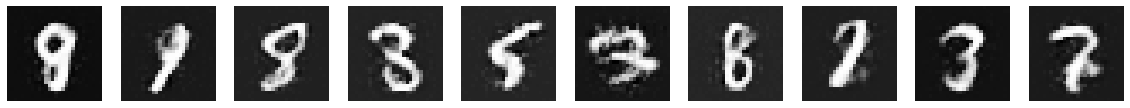

EPOCH 191/200
disc_loss: 0.4399 - gen_loss: 1.8011
EPOCH 192/200
disc_loss: 0.4401 - gen_loss: 1.7995
EPOCH 193/200
disc_loss: 0.4379 - gen_loss: 1.8065
EPOCH 194/200
disc_loss: 0.4390 - gen_loss: 1.8068
EPOCH 195/200
disc_loss: 0.4398 - gen_loss: 1.7971


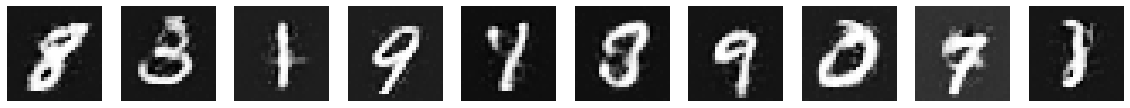

EPOCH 196/200
disc_loss: 0.4376 - gen_loss: 1.8129
EPOCH 197/200
disc_loss: 0.4383 - gen_loss: 1.8108
EPOCH 198/200
disc_loss: 0.4386 - gen_loss: 1.8059
EPOCH 199/200
disc_loss: 0.4375 - gen_loss: 1.8005
EPOCH 200/200
disc_loss: 0.4373 - gen_loss: 1.8105


In [51]:
errorG_history, errorD_history = gan.train(trainset, epochs=200)

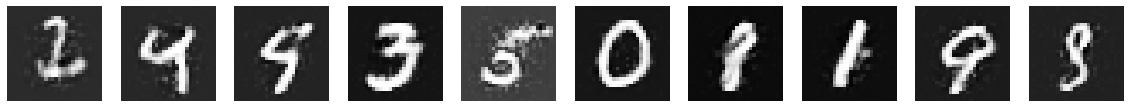

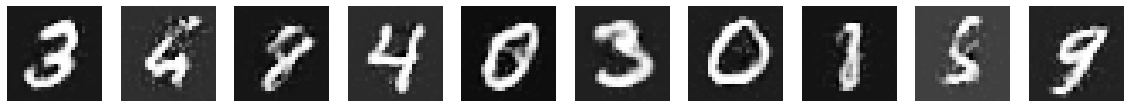

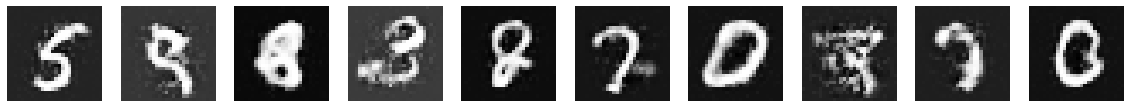

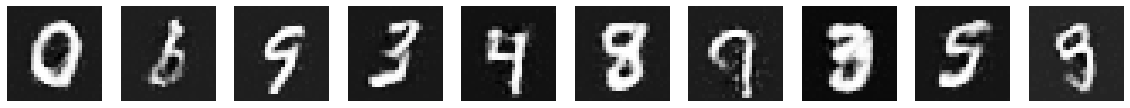

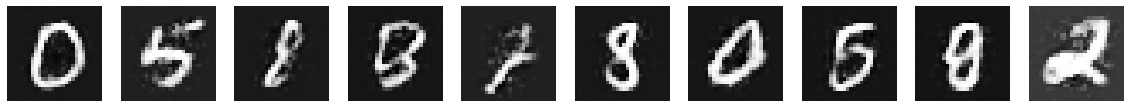

In [52]:
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()

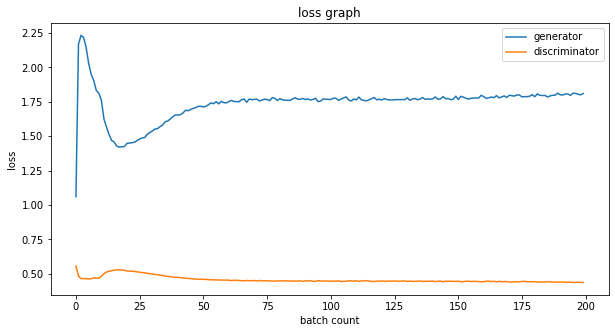

In [53]:
plt.figure(figsize=(10,5))
plt.plot(errorG_history)
plt.plot(errorD_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['generator','discriminator'])